In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'plot_cluster_annotation',
        root = '..'
    )

In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from lapa.result import LapaResult

In [3]:
df_genes = pd.read_csv(snakemake.input['genes'])
protein_coding = set(df_genes[df_genes['gene_type'] == 'protein_coding'].gene_id)

In [4]:
df = list()

for lapa_dir in snakemake.input['lapa_dir']:
    library_prep, platform, _ = Path(lapa_dir).name.split('_')
    
    if library_prep == 'quantseq':
        library_prep = 'Quantseq'

    df_cluster = LapaResult(lapa_dir).read_clusters()
    df_cluster = df_cluster[df_cluster['gene_id'].isin(protein_coding)]
    df_cluster = df_cluster[df_cluster['signal'].str.endswith('@AATAAA')]
    df_cluster = df_cluster.sort_values('usage', ascending=False).drop_duplicates(subset='gene_id')
    
    features = df_cluster['Feature'].value_counts().to_frame().T
    features = features / features.sum(axis=1).values[0]
    features['Data Source'] = f'{library_prep}\n{platform}'
    
    df.append(features)

df = pd.concat(df).reset_index(drop=True)

In [5]:
df.to_csv(snakemake.output['table'], index=False)

In [6]:
df['three_prime_utr'].mean(), df['three_prime_utr'].std()

(0.9455945163547435, 0.044451261509038255)

In [7]:
df = df.melt(id_vars='Data Source', var_name='Feature', value_name='Percentage')

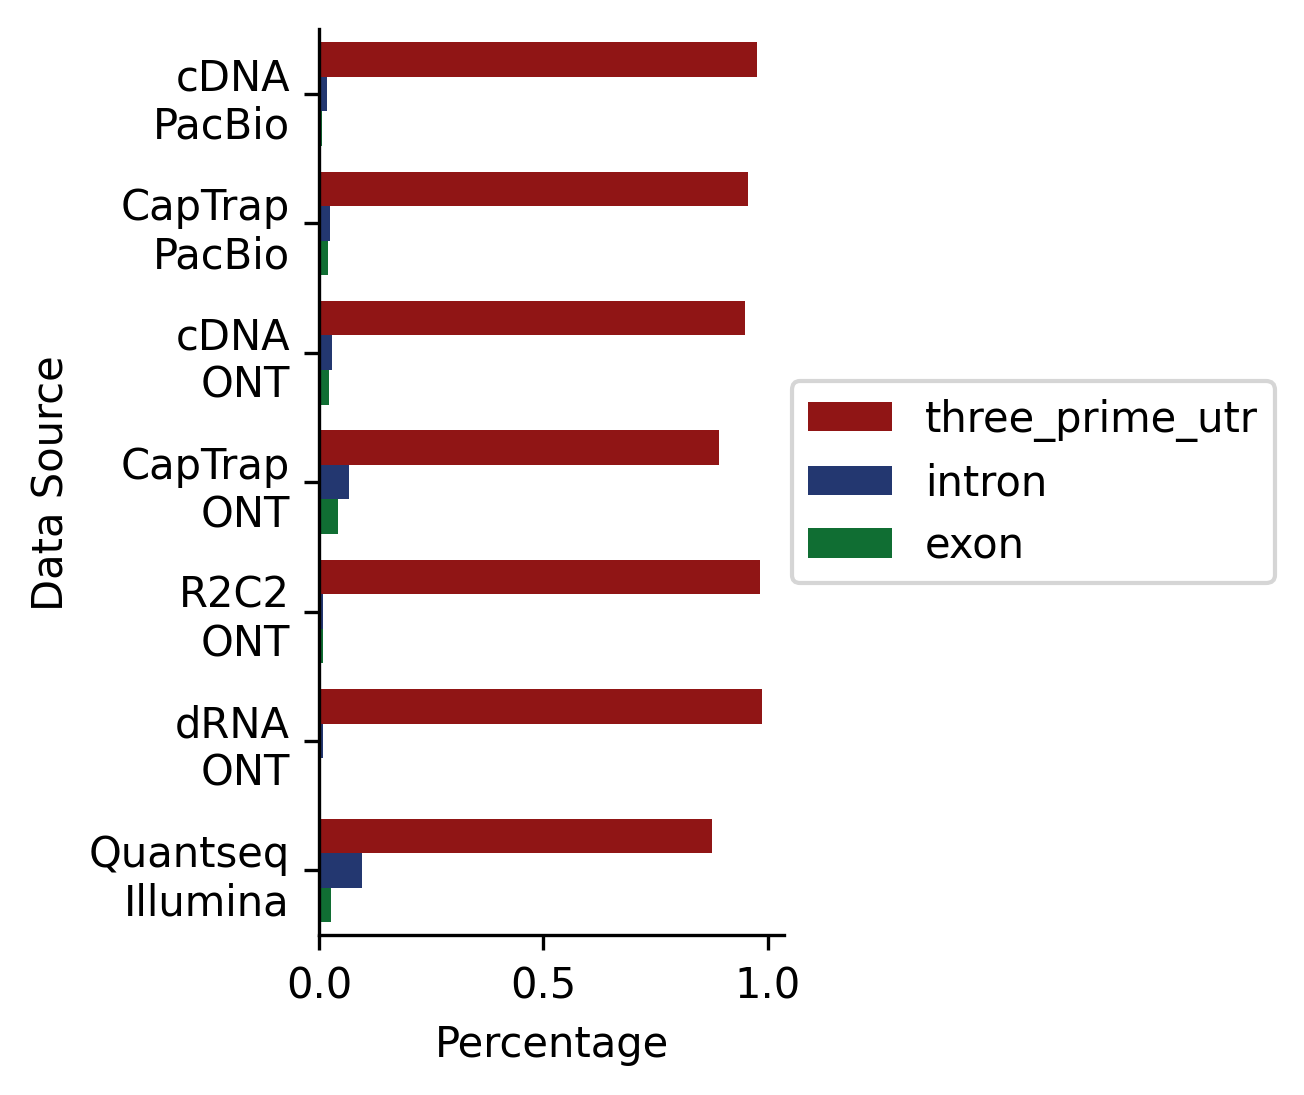

In [8]:
plt.figure(figsize=(2, 4), dpi=300)

colors=("#a40000", "#16317d", "#007e2f", "#ffcd12", "#b86092", "#721b3e", "#00b7a7")

sns.barplot(data=df, x='Percentage', y='Data Source', hue='Feature', palette=colors)
sns.despine()

plt.legend(loc='center right', bbox_to_anchor=(2.1, 0.5))
plt.savefig(snakemake.output['fig'], bbox_inches = "tight")